# Gaussian Process Distribution of Relaxation Times

## In this tutorial we will reproduce Figure 7 of the article https://doi.org/10.1016/j.electacta.2019.135316

GP-DRT is our newly developed approach that can be used to obtain both the mean and covariance of the DRT from the EIS data by assuming that the DRT is a Gaussian process (GP). The GP-DRP can  predict the DRT and the imaginary part of the impedance at frequencies that were not previously measured.

To obtain the DRT from the impedance we take that $\gamma(\xi)$ is a GP where $f$ is the frequency and $\xi=\log f$. Under the DRT model and considering that GPs are closed linear transformations, it follows that $Z^{\rm DRT}_{\rm im}\left(\xi\right)$ is also a GP.

More precisely we can write

$$\begin{pmatrix}
\gamma(\xi) \\
Z^{\rm DRT}_{\rm im}\left(\xi\right)
\end{pmatrix}\sim \mathcal{GP}\left(\mathbf 0, \begin{pmatrix}
k(\xi, \xi^\prime) & \mathcal L^{\rm im}_{\xi^\prime} \left(k(\xi, \xi^\prime)\right)\\
\mathcal L^{\rm im}_{\xi} k(\xi, \xi^\prime) & \mathcal L^{\rm im}_{\xi^\prime}\left(\mathcal L^{\rm im}_{\xi} \left(k(\xi, \xi^\prime)\right)\right)
\end{pmatrix}\right)$$

where

$$\mathcal L^{\rm im}_\xi \left(\cdot\right) = -\displaystyle \int_{-\infty}^\infty \frac{2\pi \displaystyle e^{\xi-\hat \xi}}{1+\left(2\pi \displaystyle e^{\xi-\hat \xi}\right)^2}  \left(\cdot\right) d \hat \xi$$

is a linear functional. The latter functional, transforms the DRT to the imaginary part of the impedance.

Assuming we have $N$ observations, we can set $\left(\mathbf Z^{\rm exp}_{\rm im}\right)_n = Z^{\rm exp}_{\rm im}(\xi_n)$ with $\xi_n =\log f_n$ and $n =1, 2, \ldots N $. The corresponding multivariate Gaussian random variable can be written as 

$$\begin{pmatrix}
\boldsymbol{\gamma} \\
\mathbf Z^{\rm exp}_{\rm im}
\end{pmatrix}\sim \mathcal{N}\left(\mathbf 0, \begin{pmatrix}
\mathbf K & \mathcal L_{\rm im} \mathbf K\\
\mathcal L_{\rm im}^\sharp \mathbf K & \mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I
\end{pmatrix}\right)$$

where 

$$\begin{align}
(\mathbf K)_{nm} &= k(\xi_n, \xi_m)\\
(\mathcal L_{\rm im} \mathbf K)_{nm} &= \left. \mathcal L^{\rm im}_{\xi^\prime} \left(k(\xi, \xi^\prime)\right) \right |_{\xi_n, \xi_m}\\
(\mathcal L_{\rm im}^\sharp \mathbf K)_{nm} &= \left.\mathcal L^{\rm im}_{\xi} \left(k(\xi, \xi^\prime)\right) \right|_{\xi_n, \xi_m}\\
(\mathcal L^2_{\rm im} \mathbf K)_{nm} &= \left.\mathcal L^{\rm im}_{\xi^\prime}\left(\mathcal L^{\rm im}_{\xi} \left(k(\xi, \xi^\prime)\right)\right) \right|_{\xi_n, \xi_m}
\end{align}$$

and $\mathcal L_{\rm im} \mathbf K^\top = \mathcal L_{\rm im}^\sharp \mathbf K$.

To obtain the DRT from impedance, the distribution of $\mathbf{\gamma}$ conditioned on $\mathbf Z^{\rm exp}_{\rm im}$ can be written as

$$\boldsymbol{\gamma}|\mathbf Z^{\rm exp}_{\rm im}\sim \mathcal N\left( \mathbf \mu_{\gamma|Z^{\rm exp}_{\rm im}}, \mathbf\Sigma_{\gamma| Z^{\rm exp}_{\rm im}}\right)$$

with

$$\begin{align}
\mathbf \mu_{\gamma|Z^{\rm exp}_{\rm im}} &= \mathcal L_{\rm im} \mathbf K \left(\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I \right)^{-1} \mathbf Z^{\rm exp}_{\rm im} \\
\mathbf \Sigma_{\gamma| Z^{\rm exp}_{\rm im}} &= \mathbf K- \mathcal L_{\rm im} \mathbf K \left(\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I \right)^{-1}\mathcal L_{\rm im} \mathbf K^\top
\end{align}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
%matplotlib inline

## 1) Define parameters of the ZARC circuit which will be used for the synthetic experiment generation

The impedance of a ZARC can be written as
$$
Z^{\rm exact}(f) = R_\infty + \displaystyle \frac{1}{\displaystyle \frac{1}{R_{\rm ct}}+C \left(i 2\pi f\right)^\phi}
$$

where $\displaystyle C = \frac{\tau_0^\phi}{R_{\rm ct}}$.

The analytical DRT can be computed analytically as

$$
\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0))-\cos(\pi(1-\phi))}
$$

In [2]:
# number of frequencies
N_freqs = 81

# define the frequency range
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction
# note: we could have used other values
freq_vec_star = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for ZARC model, the impedance and analytical DRT are calculated as the above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.

C = tau_0**phi/R_ct
Z_exact = R_inf+1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# we will use a finer mesh for plotting the results
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi)) # for plotting only

# we will add noise to the impedance computed analytically
rng = np.random.seed(214975)
sigma_n_exp = 1.
Z_exp = Z_exact + (sigma_n_exp**2)*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 2) Show the synthetic impedance in the Nyquist plot - this is similar to Figure 7 (a)

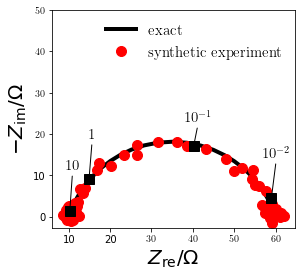

In [3]:
# Nyquist plot of the impedance
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synthetic experiment")
plt.plot(np.real(Z_exp[20:60:10]), -np.imag(Z_exp[20:60:10]), 's', markersize=10, color="black")

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
# label the frequency points
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 10-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-2, 6-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40]), 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-1, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.show()

## 3) Obtain the optimal hyperparameters of the GP-DRT model by minimizing the negative marginal log likelihood (NMLL)

We constrain the kernel to be a squared exponential, {\it i.e.},

$$
k(\xi, \xi^\prime) = \sigma_f^2 \exp\left(-\frac{1}{2 \ell^2}\left(\xi-\xi^\prime\right)^2 \right)
$$

and modify its two parameters, $\sigma_f$ and $\ell$ as well as the noise level $\sigma_n$. Therefore, the vector of hyperparameters of the GP-DRT is assumed to be $\boldsymbol \theta = \begin{pmatrix} \sigma_n, \sigma_f, \ell  \end{pmatrix}^\top$.

Following the same derivation from the article we can write that

$$
\log p(\mathbf Z^{\rm exp}_{\rm im}|\boldsymbol \xi, \boldsymbol \theta)= - \frac{1}{2} {\mathbf Z^{\rm exp}_{\rm im}}^\top \left(\mathcal L^2_{\rm im} \mathbf K +\sigma_n^2\mathbf I \right)^{-1} \mathbf Z^{\rm exp}_{\rm im} -\frac{1}{2} \log \left| \mathcal L^2_{\rm im} \mathbf K+\sigma_n^2\mathbf I  \right| - \frac{N}{2} \log 2\pi
$$

We will call $L(\boldsymbol \theta)$ the negative (and shifted) MLL (NMLL):
$$
L(\boldsymbol \theta) = - \log p(\mathbf Z^{\rm exp}_{\rm im}|\boldsymbol \xi, \boldsymbol \theta) - \frac{N}{2} \log 2\pi
$$

the experimental evidence is maximized for

$$
\boldsymbol \theta = {\rm argmin}_{\boldsymbol \theta^\prime}L(\boldsymbol \theta^\prime)
$$

In [4]:
# initialize the parameter for global 3D optimization to maximize the marginal log-likelihood as shown in eq (31)
sigma_n = sigma_n_exp
sigma_f = 5.
ell = 1.

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%f, %f, %f' %(theta[0], theta[1], theta[2]))
    
print('sigma_n,  sigma_f,  ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_f, ell using the Newton-CG method as implemented in scipy
res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', \
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_f, ell = res.x

sigma_n,  sigma_f,  ell
0.890360, 5.001415, 1.012087
0.813635, 5.003534, 1.029191
0.829186, 5.035787, 1.258867
0.830393, 5.083238, 1.211778
0.830449, 5.206076, 1.228366
0.830519, 5.387441, 1.252415
0.830523, 5.406900, 1.254665
0.830526, 5.407098, 1.254689
0.830527, 5.407092, 1.254687
Optimization terminated successfully.
         Current function value: 53.657989
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 153
         Hessian evaluations: 0


## 4) Core of the GP-DRT

### 4a) Compute matrices
Once we have identified the optimized parameters we can compute $\mathbf K$, $\mathcal L_{\rm im} \mathbf K$, and $\mathcal L^2_{\rm im} \mathbf K$, which are given in equation (18) in the article

In [5]:
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

# in the next step we will need the inverse of the matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$ 
K_im_full = L2_im_K + Sigma

### 4b) Factorize the matrices and solve the linear equations
We are computing
$$
\boldsymbol{\gamma}|\mathbf Z^{\rm exp}_{\rm im}\sim \mathcal N\left( \boldsymbol \mu_{\gamma|Z^{\rm exp}_{\rm im}}, \boldsymbol \Sigma_{\gamma| Z^{\rm exp}_{\rm im}}\right)
$$

using 
$$
\begin{align}
\boldsymbol \mu_{\gamma|Z^{\rm exp}_{\rm im}} &= \mathcal L_{\rm im} \mathbf K\left(\mathcal L^2_{\rm im} \mathbf K+\sigma_n^2\mathbf I\right)^{-1}\mathbf Z^{\rm exp}_{\rm im} \\
\boldsymbol \Sigma_{\gamma| Z^{\rm exp}_{\rm im}} &= \mathbf K-\mathcal L_{\rm im} \mathbf K\left(\mathcal L^2_{\rm im} \mathbf K+\sigma_n^2\mathbf I\right)^{-1}\mathcal L_{\rm im} \mathbf K^\top
\end{align}
$$

The key ingredient is to do Cholesky factorization of $\mathcal L^2_{\rm im} \mathbf K+\sigma_n^2\mathbf I$

In [6]:
# Cholesky factorization, L is a lower-triangular matrix
L = np.linalg.cholesky(K_im_full)

# solve the following
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma of eq (21a), the minus sign, which is not included in L_im_K, refers to eq (65)
gamma_fct_est = -np.dot(L_im_K.T, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)
np.diag(np.dot(inv_K_im_full, K_im_full))

# estimate the sigma of gamma, from eq (21b)
cov_gamma_fct_est = K - np.dot(L_im_K.T, np.dot(inv_K_im_full, L_im_K))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

### 4c) Plot the obtained DRT against the analytical DRT

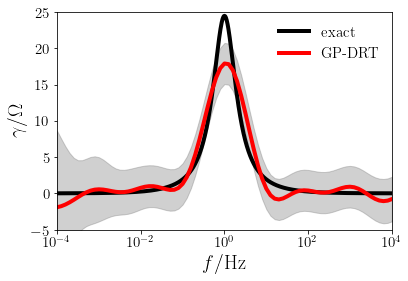

In [7]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec, gamma_fct_est, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec, gamma_fct_est-3*sigma_gamma_fct_est, gamma_fct_est+3*sigma_gamma_fct_est, color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

### 4d) Predict the $\gamma$ and the imaginary part of the GP-DRT impedance

This part is explained in Section 2.3.3 of the main article 

In [8]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for the plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (18), k_star corresponds to a new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star = GP_DRT.matrix_L_im_K(xi_vec, xi_star, sigma_f, ell)
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_vec, xi_star, sigma_f, ell)
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation using eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute Z_im_star mean and standard deviation
    gamma_vec_star[index] = -np.dot(L_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star.T, np.dot(inv_K_im_full, L_im_k_star))

### 4e) Plot the imaginary part of the GP-DRT impedance together with the exact one and the synthetic experiment

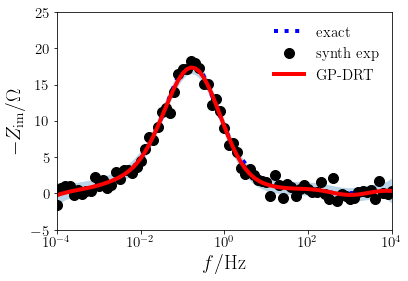

In [9]:
plt.semilogx(freq_vec_star, -np.imag(Z_exact), ":", linewidth=4, color="blue", label="exact")
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()